![](brain.png)

In [1]:
import numpy as np
import matplotlib.pyplot as plot
import time

# Descentes batch, mini batch et stochastique

## Mise en situation
Je travaille pour un fournisseur d'accès internet. Je voudrais afficher une estimation du débit théorique moyen par rappot à la distance au central aux personnes qui souhaitent souscrire chez nous.

Je dispose du débit moyen sur 6 heures pour chacun de nos abonnés : des milliards de données !!!

Le modèle n'est probablement pas compliqué mais chaque itération de la descente de gradient me prend des heures... c'est pas près de converger ! (J'ai bien entendu normalisé mes données, pour converger "plus vite", mais "plus vite" = "moins d'étapes" : chaque étape prenant pas mal de temps $\rightarrow$ ça peut être long quand même...)

## Descentes mini batch et stochastique
### C'est quoi ?
Jusque-là, nous n'avons utilisé que des descentes "batch" : on calcule l'erreur sur ***l'ensemble*** du jeu de données, et de là on en tire le gradient qui nous indique la descente à suivre.

Cette méthode nous permet d'être certain d'une chose (sous réserve d'avoir correctement choisi $\alpha$) : la fonction de coût décroit à chaque étape.

Changeons de méthode un instant. Au lieu de calculer l'erreur de l'ensemble du jeu de données, on ne calcule l'erreur que d'un seul exemple, et on applique la descente, puis on recommence pour l'itération suivante avec un autre exemple, etc...

Avec cette approche, on n'est certain que d'une chose : on a appliqué la descente par rapport à **un seul exemple**, on fait effectivement mieux, **pour cet exemple uniquement**. Il est possible d'avoir _globalement_ mieux, mais si cet exemple était un peu erronné ou biaisé non.

Une autre conséquence est qu'on va probablement tourner autour du minimum, sans vraiment converger.

### Visualisation 2D
Pour mieux voir de quoi il retourne, un petit exemple visuel

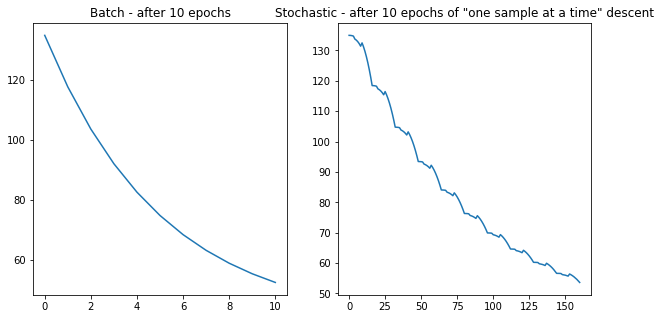

In [2]:
# On choisit une fonction simpliste : f(x) = x + 1
def f(x): return x[:,0] + 1.0
def cost(x, y, theta0, theta1):
    errs =  x[:,0] * theta1 + theta0 - y
    return np.sum(errs**2)/x.shape[0]

samples = 16
X = np.arange(samples).reshape(samples,1) + 1
Y = f(X).reshape(samples,1)
# on fausse quelques données
Y[3,0] += 15
Y[8,0] -= 20

def gradient_descent(x, y, batch_size, alpha = 0.001, epochs = 10):
    m = x.shape[0]
    Xtmp = np.concatenate([np.ones((m,1)), x], axis = 1)
    
    theta = np.zeros((Xtmp.shape[1], 1))
    costs = []
    
    for e in range(epochs):
        # A chaque itération, on ne traite qu'une partie des données
        for j in range(0, m, batch_size):
            costs.append(cost(Xtmp, y, theta))
            Xbatch = Xtmp[j:j+batch_size, :]
            Ybatch = y[j:j+batch_size, :]
            grad = np.dot(Xbatch.T, np.dot(Xbatch, theta) - Ybatch)/m
            theta = theta - alpha * grad
    costs.append(cost(Xtmp, y, theta))
    return theta, costs

def cost(x, y, theta):
    return np.sum((np.dot(x, theta)-y)**2)/x.shape[0]

fig = plot.figure(figsize=(10,5))
ax = fig.add_subplot(121)
theta_batch, costs_batch = gradient_descent(X, Y, samples)
ax.plot(np.arange(len(costs_batch)), costs_batch)
t = plot.title('Batch - after 10 epochs')

ax = fig.add_subplot(122)
theta_sto, costs_sto = gradient_descent(X, Y, 1)
ax.plot(np.arange(len(costs_sto)), costs_sto)
t = plot.title('Stochastic - after 10 epochs of "one sample at a time" descent')

Comme prévu, on constate bien qu'en mode batch, on ne fait que descendre.

En mode "1 seul exemple", on descend _le plus souvent_ mais la fonction de coût ne descend pas à chaque étape.

On appelle ce mode le mode "stochastique" parce que normalement, il faudrait traiter les différents exemples un par un dans un ordre aléatoire.

### Un peu de vocabulaire
* Une itération de la descente de gradient correspond à l'étape où on met $\theta$ à jour.
* Traiter tous les exemples du jeu de données s'appelle une _époque_ (ou _epoch_ en anglais)

Dans le cadre du *BGD* (Batch gradient descent), une époque est une itération. Dans le cadre du *SGD* (Stochastic gradient descent), une époque comporte autant d'itérations que d'exemples dans le jeu de données.

### La descente "Mini batch"
La descente stochastique est très pratique : on descend globalement, pas aussi efficacement qu'en batch, mais en tous les cas les itérations prennent beaucoup moins de temps.

Un autre inconvénient (en plus des oscillations) est le temps de traitement d'une époque complète : il est plus rapide de traiter un seul exemple que tout le paquet, mais il est beaucoup plus long de traiter chaque exemple un par un que de traiter tout le paquet en bloc :
* le produit matriciel est largement optimisé en général (et avec _numpy_ en particulier)
* suivant les implémentations, les capacités de la machines peuvent être largement exploitées aussi (par exemple, distribution des calculs sur plusieurs CPU)

Pour essayer de combiner les avantages des uns et des autres, on va introduire une nouvelle méthode : le **MBGD** (mini batch gradient descent). Au lieu de traiter tous les exemples en bloc, ou de les traiter un par un, on va les traiter par "petits paquets".


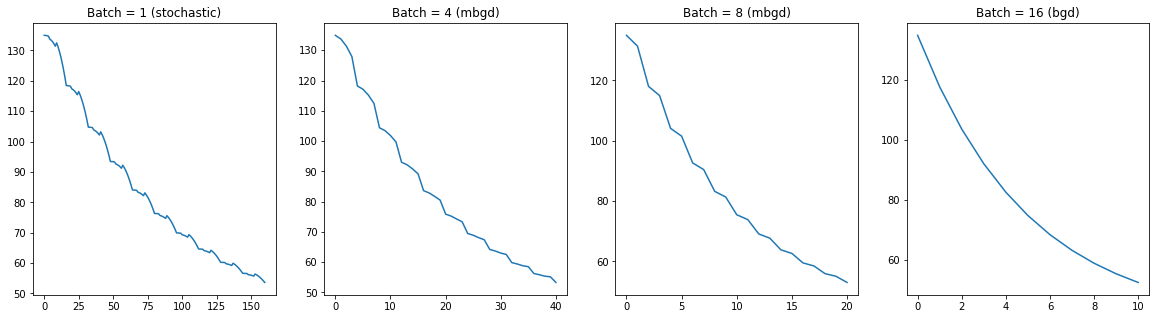

In [3]:
fig = plot.figure(figsize=(20,5))
ax = fig.add_subplot(141)
theta_batch, costs_batch = gradient_descent(X, Y, 1)
ax.plot(np.arange(len(costs_batch)), costs_batch)
t = plot.title('Batch = 1 (stochastic)')

ax = fig.add_subplot(142)
theta_sto, costs_sto = gradient_descent(X, Y, 4)
ax.plot(np.arange(len(costs_sto)), costs_sto)
t = plot.title('Batch = 4 (mbgd)')

ax = fig.add_subplot(143)
theta_sto, costs_sto = gradient_descent(X, Y, 8)
ax.plot(np.arange(len(costs_sto)), costs_sto)
t = plot.title('Batch = 8 (mbgd)')

ax = fig.add_subplot(144)
theta_sto, costs_sto = gradient_descent(X, Y, 16)
ax.plot(np.arange(len(costs_sto)), costs_sto)
t = plot.title('Batch = 16 (bgd)')

Plus le paquet est gros, plus la courbe se lisse, mais plus la durée d'une itération est importante

### Note concernant les tailles de mini-batch
Comme expliqué plus haut, un gros avantage du BGD est qu'il optimise les produits matriciels. Le MBGD en profite aussi.

Les algorithmes optimisés de produits matriciels sont pour la plupart basés sur du _divide to reign_ : la matrice est divisée en 4 blocs (2x2) et les produits sont appliqués aux sous-blocs, récursivement.

Pour profiter vraiment de cet avantage en mode MBGD, il est plus intéressant de choisir comme taille de batch une puissance de 2, tailles pour lesquelles le produit matriciel sera optimal.

## Retour à la mise en situation

### Chargement des données
Au vu du cas traité aujourd'hui, les données sont compressées. Il faut ce qu'il faut :D

In [4]:
data_1 = np.load('data/d05_data_1.npz')
data_2 = np.load('data/d05_data_2.npz')
x_train = np.concatenate([data_1['x'], data_2['x']], axis = 0)
y_train = np.concatenate([data_1['y'], data_2['y']], axis = 0)

m = x_train.shape[0]
print("%i rows loaded" % m)

16777216 rows loaded


_Note: pour comparer uniquement le temps de la descente, les données sont déjà normalisées et la colonne $x_0$ est déjà ajoutée_

La descente BGD prend moins de temps pour une époque, et son résultat est même meilleur. Mais si on travaille sur un nombre fixe d'itérations, les itérations sont beaucoup plus rapides en MBGD

In [5]:
def gradient_descent_iter(x, y, batch_size, alpha = 0.001, iterations = 10):
    m = x.shape[0]
    
    #Normalisation (note : le 1e-9 ne sert qu'à éviter une division par zéro potentielle...)
    mus = np.mean(x)
    sigmas = np.std(x) + 1e-9
    
    Xtmp = np.concatenate([np.ones((m, 1)), (x-mus)/sigmas], axis = 1)
    
    theta = np.zeros((x.shape[1], 1))
    costs = []
    
    batch_start = 0
    for i in range(iterations):
        # A chaque itération, on ne traite qu'une partie des données
        Xbatch = x[batch_start:batch_start+batch_size, :]
        Ybatch = y[batch_start:batch_start+batch_size, :]
        grad = np.dot(Xbatch.T, np.dot(Xbatch, theta) - Ybatch)/m
        theta = theta - alpha * grad
        batch_start += batch_size
        if batch_start >= m: batch_start = 0
    return theta

In [6]:
start_time = time.time()
theta_bgd = gradient_descent_iter(x_train, y_train, m, alpha = 0.1, iterations = 1)
print("BGD : one epoch in %f seconds" % (time.time() - start_time))

start_time = time.time()
theta_mbgd = gradient_descent_iter(x_train, y_train, 256, alpha = 0.1, iterations = 100)
print("MBGD : 100 iterations in %f seconds" % (time.time() - start_time))

start_time = time.time()
theta_mbgd = gradient_descent_iter(x_train, y_train, 256, alpha = 0.1, iterations = m//256)
print("MBGD : one epoch in %f seconds" % (time.time() - start_time))

BGD : one epoch in 1.148031 seconds
MBGD : 100 iterations in 1.044559 seconds
MBGD : one epoch in 1.902879 seconds


On constate qu'une seule itération du BGD prend beaucoup plus de temps qu'une itération MBGD.

Par contre, pour un nombre d'époques équivalent, MBGD est en théorie plus long, mais pas toujours : ça dépend de la machine.

**Note importante** : si la taille du batch est trop importante pour la mémoire de la machine, le temps passé en swap risque d'inverser ce résultat, on passera plus de temps à traiter le batch entier que des mini batchs qui tiennent en mémoire.